# 1. Init

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
from operator import itemgetter
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

# 2.  Cleaning

In [2]:
''' Data Cleaning '''

conn = sqlite3.connect('../../Data/Experiment_3/Bryan_exp3_remote.db')
dat = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion=1', con=conn)

# Only use indices where comprehension questions were answered correctly
anim = dat.loc[(dat.anim_check == 1) & (dat.tower_check == 1 ) & (dat.agent_check==1)]
inanim = dat[['inanim' in x for x in dat.exp_cond]].loc[(dat.anim_check == 1) & (dat.tower_check == 1 )] # animate condition had a third comprehension check
inanim['exp_cond'] = 'inanimate' # this should collapse the 'moral' and 'rational' conditions in the inanimate case, where they don't mean anything
dat = pd.concat([anim, inanim])
# remove duplicate columns that came from the SQL inner join
dat = pd.DataFrame(dat.values[:,~dat.columns.duplicated()], columns=dat.columns[~dat.columns.duplicated()])
# remove subjects who somehow ended up with multiple rows (from refreshing or some other unknown reason)
xx = dat.groupby('prolificID').count().id > 1
extrasubs = xx.loc[xx.values == True].index.tolist()
for subj in extrasubs:
    b = dat.loc[dat.prolificID == subj].index == dat.loc[dat.prolificID == subj].index.max() # take only the final attempt at the task
    dat.drop(dat.loc[dat.prolificID == subj].index[~b], inplace=True)

#  slider data recorded as lists, to capture when pps might have changed their minds.
#  reformate from list to final value
for prompt in ["Q0", "Q1", "Q2","Q3"]:
    dat[prompt] = dat[prompt].apply(literal_eval)
    dat['num_moves'+prompt] = [len(x) for x in dat[prompt]]
    dat['Q'+prompt] = dat[prompt].map(lambda x: x[-1]) # last value in the list, aka pps final answer

del anim, inanim, xx, extrasubs, b, subj, prompt

# n's are not matching. Lowest is animate moral (98) drop random index so they match
dat.drop(np.random.choice(dat.loc[dat.exp_cond == 'animate_rational'].index, size=3), inplace=True)
dat.drop(np.random.choice(dat.loc[dat.exp_cond == 'inanimate'].index, size=1), inplace=True)
dat.reset_index(drop=True, inplace=True)
dat.rename(columns={'exp_cond': 'condition'}, inplace=True)
dat.groupby('condition').subject_id.count()

condition
animate_moral       98
animate_rational    98
inanimate           98
Name: subject_id, dtype: int64

# 3. Plotting

## 3.1 Norm Violation
Participants formed an expectation of what the animate agents _should_ do, and perceived its movements as a violation.
Participants did not judge the inanimate agent as violating their expectations.

Text(0.5, 0, '')

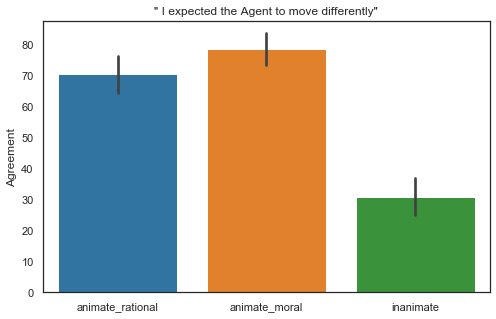

In [3]:
plt.figure(figsize=(8,5))
sns.barplot(x='condition', y='Agreement', data=dat.melt(id_vars=['subject_id', 'condition'], value_vars='QQ2', var_name='prompt', value_name='Agreement'))
plt.title('\" I expected the Agent to move differently\"')
plt.xlabel("")

## 3.2 Whether-cause
The agreement ratings below are with respect to the statement _\"If the agent/patient had not been there, the tower would have remained standing.\"_
Agreement, indicates the extent to which participants judged the agent/patient as a whether cause.

### 3.2.1 Whether-cause: Rational norm violation

When the <span style='color:Green;'>agent</span> does something irrational (knock the <span style='color:#F455E3;'>patient</span> into its {_the<span style='color:green;'> agent's</span>_} own tower):
![Figures/anim_rational.png](Figures/anim_rational.png )

(0, 100)

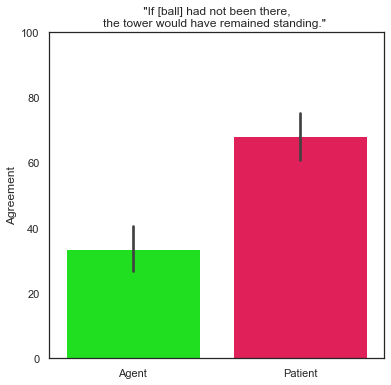

In [4]:
dat_long = dat.rename(columns={'QQ0': 'Agent', 'QQ1': 'Patient'}).melt(id_vars=['subject_id', 'condition'],
                    value_vars=['Agent','Patient'],
                    var_name='prompt', value_name='Agreement')
plt.figure(figsize=(6,6))
g = sns.barplot(x='prompt', y='Agreement', data=dat_long.loc[dat_long.condition=='animate_rational'], palette=[(0., 1., 0., 0.6), (1., 0., 0.3, 0.6)])
plt.title(" \"If [ball] had not been there, \nthe tower would have remained standing.\" ")
plt.xlabel("")
plt.ylim([0, 100])


*  **The <span style='color:Green;'>agent</span>** is judged as less of a whether cause.  Suggesting participants believed the <span style='color:#F455E3;'>patient</span> _was_ going to knock the tower down on its own, in the absence of the <span style='color:Green;'>agent</span>.
*  **The <span style='color:#F455E3'> patient</span>** is judged as more of a whether cause. Suggesting that if the <span style='color:#F455E3'>patient</span> had not been there, participants believed the <span style='color:Green;'>agent</span> _was not_ going to knock down its own tower. (does this mean bad manipulation?)



### 3.2.2 Whether-cause: Moral norm violation

When the <span style='color:#F455E3;'>agent</span> does something immoral (knock the <span style='color:Green;'>patient</span> into its {_the <span style='color:green;'>patient</span>'s_} own tower):
![Figures/anim_moral.png](Figures/anim_moral.png )

(0, 100)

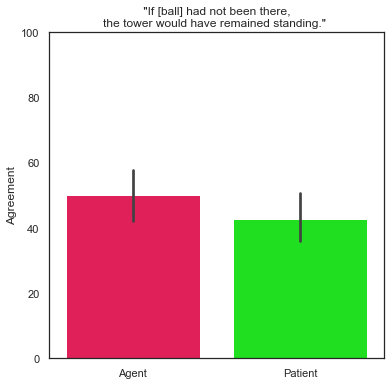

In [5]:
plt.figure(figsize=(6,6))
g = sns.barplot(x='prompt', y='Agreement', data=dat_long.loc[dat_long.condition=='animate_moral'], palette=[ (1., 0., 0.3, 0.6), (0., 1., 0., 0.6)])
plt.title(" \"If [ball] had not been there, \nthe tower would have remained standing.\" ")
plt.xlabel("")
plt.ylim([0, 100])


* Little-to-no difference between whether-cause judgements for <span style='color:#F455E3;'>agent</span> and <span style='color:green;'>patient</span>
* **The <span style='color:green'> patient</span>** is judged as slightly less of a whether cause. Suggesting that if the <span style='color:green;'>patient</span> had not been there, participants _do_ believe the <span style='color:#F455E3;'>agent</span> would have knocked down the (<span style='color:green;'>patient's</span>) tower on its own.

### 3.2.3 Whether-cause: Inanimate

When both balls are perceived as inanimate, neither is judged as a whether-cause.
![Figures/inanim.png](Figures/inanim.png )
This makes sense given that the outcome was  over-determined.

(0, 100)

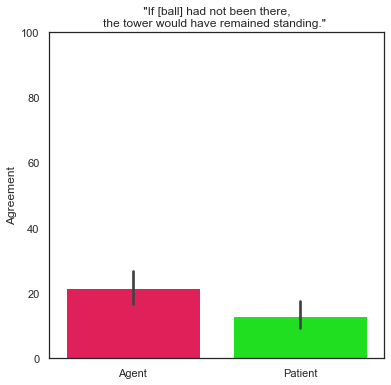

In [6]:
plt.figure(figsize=(6,6))
g = sns.barplot(x='prompt', y='Agreement', data=dat_long.loc[dat_long.condition=='inanimate'], palette=[ (1., 0., 0.3, 0.6), (0., 1., 0., 0.6)])
plt.title(" \"If [ball] had not been there, \nthe tower would have remained standing.\" ")
plt.xlabel("")
plt.ylim([0, 100])

### 3.2.4 Whether-cause: All Conditions


Text(12.084999999999987, 0.5, 'Whether Cause Judgement')

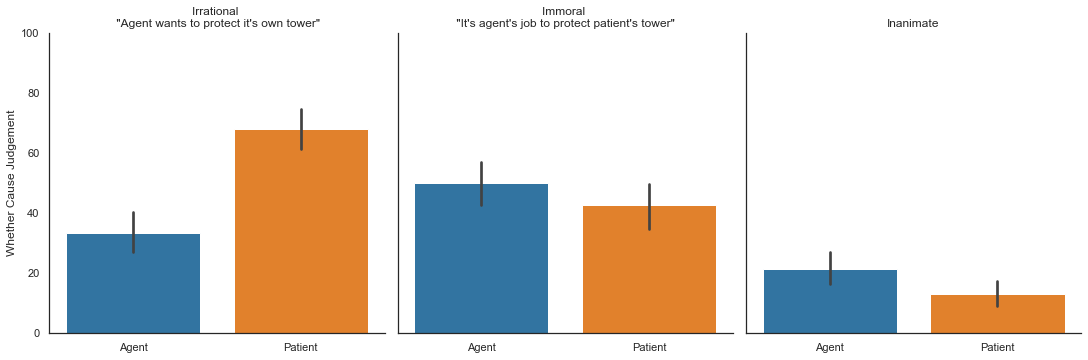

In [7]:
g = sns.catplot(x='prompt', y='Agreement', col='condition', kind='bar', data=dat_long)
plt.ylim([0,100])
prompts = ["Irrational \n \"Agent wants to protect it's own tower\"", "Immoral \n \"It's agent's job to protect patient's tower\" ", "Inanimate"]
for i, p in enumerate(prompts):
    g.axes[0][i].set_xlabel("")
    g.axes[0][i].set_title(p)

g.axes[0][0].set_ylabel("Whether Cause Judgement")

## 3.3 How-cause

[None, None, None]

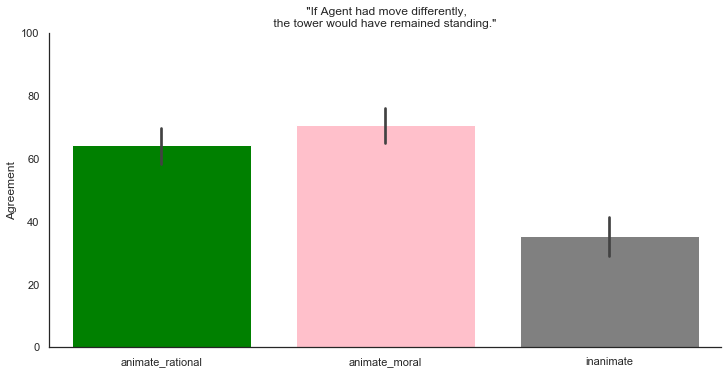

In [8]:
dat_long2 = dat.melt(id_vars=['subject_id', 'condition'],
                    value_vars=['QQ3'],
                    var_name='prompt', value_name='Agreement')

g = sns.catplot(x='condition', y='Agreement', kind='bar', data=dat_long2, aspect=2)
plt.ylim([0,100])
plt.xlabel("")
g.axes[0][0].set_title(" \"If Agent had move differently,\n the tower would have remained standing.\" ")
[g.axes[0][0].patches[i].set_facecolor(colour) for i, colour in enumerate(['green', 'pink', 'grey'])]


# 4. Answer distributions

In [44]:
dat['exp_cond'] = dat.condition.map(lambda x: x.split('_'))
dat['animacy'] = [dat.exp_cond[x][0] for x in range(len(dat))]
dat['norm_violation'] = [dat.exp_cond[x][1] if dat.exp_cond[x][0]=='animate' else 'inanimate' for x in range(len(dat)) ]
dat.drop('exp_cond', axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/

Text(0.5, 0, ' "If PATIENT had not been there, \nthe tower would have remained standing." ')

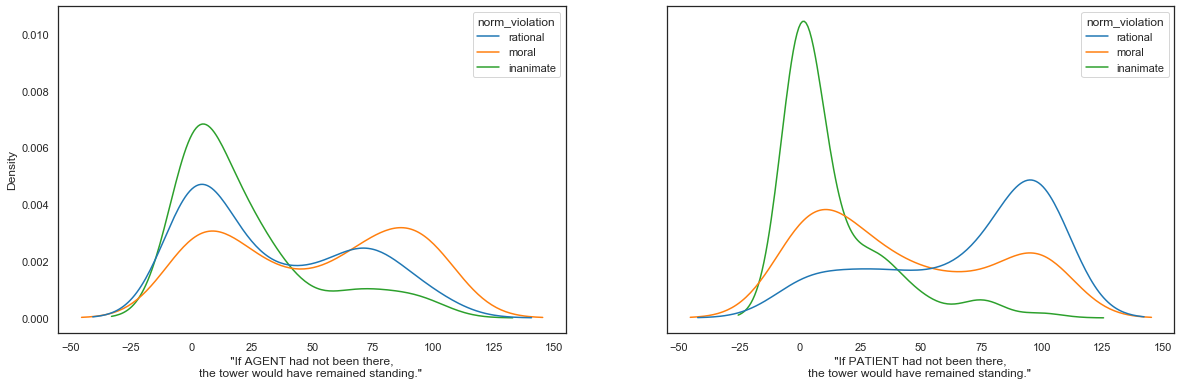

In [59]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
sns.kdeplot(data=dat, x='QQ0', hue='norm_violation', ax=ax[0])
ax[0].set_xlabel(" \"If AGENT had not been there, \nthe tower would have remained standing.\" ")
sns.kdeplot(data=dat, x='QQ1', hue='norm_violation', ax=ax[1])
ax[1].set_xlabel(" \"If PATIENT had not been there, \nthe tower would have remained standing.\" ")


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/

Text(0.5, 0, '"If AGENT  had moved in a different way, the tower would have remained standing."')

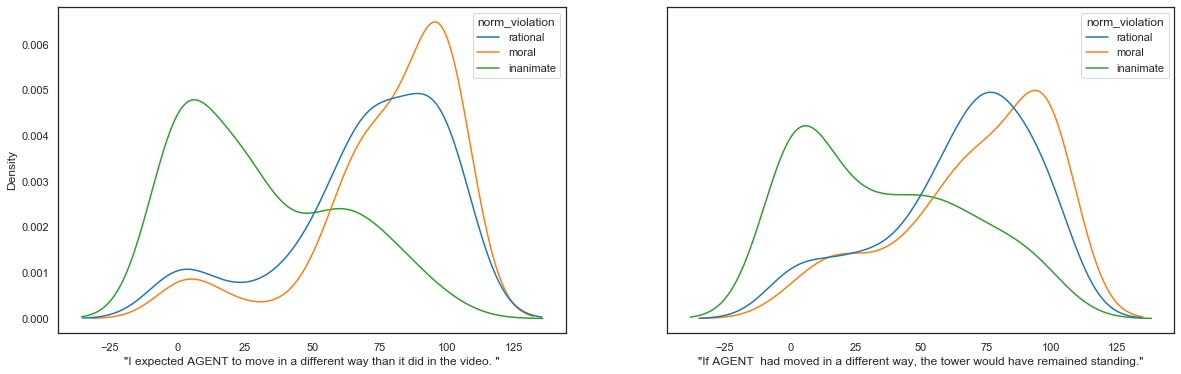

In [58]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
sns.kdeplot(data=dat, x='QQ2', hue='norm_violation', ax=ax[0])
ax[0].set_xlabel('\"I expected AGENT to move in a different way than it did in the video. \"')
sns.kdeplot(data=dat, x='QQ3', hue='norm_violation', ax=ax[1])
ax[1].set_xlabel('\"If AGENT  had moved in a different way, the tower would have remained standing.\"')


test code

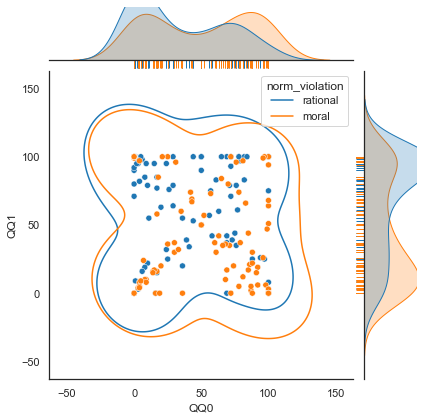

In [46]:
g = sns.jointplot(data=dat.loc[dat.animacy=='animate'], x="QQ0", y="QQ1", hue='norm_violation')
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=1)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

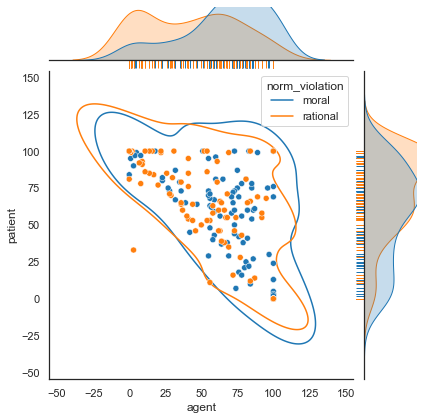

In [40]:
g = sns.jointplot(data=e2dat.loc[e2dat.animacy=='animate'], x="agent", y="patient", hue='norm_violation')
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=1)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

# 4. Compare with Experiment 2 results

In [9]:
conn = sqlite3.connect('../../Data/Experiment_2/exp2_remote.db')
e2dat = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion=1', con=conn)
# Only use rows where comprehension questions were answered correctly
anim = e2dat.loc[(e2dat.anim_check == 1) & (e2dat.tower_check == 1 ) & (e2dat.agent_check==1)]
inanim = e2dat[['inanim' in x for x in e2dat.exp_cond]].loc[(e2dat.anim_check == 1) & (e2dat.tower_check == 1 )]
#inanim['exp_cond'] = 'inanimate'
e2dat = pd.concat([anim, inanim])
# remove duplicate columns that came from the SQL inner join
e2dat = pd.DataFrame(e2dat.values[:,~e2dat.columns.duplicated()], columns=e2dat.columns[~e2dat.columns.duplicated()])
# remove subjects who somehow ended up with multiple rows
xx = e2dat.groupby('prolificID').count().id > 1
extrasubs = xx.loc[xx.values == True].index.tolist()
for subj in extrasubs:
    b = e2dat.loc[e2dat.prolificID == subj].index == e2dat.loc[e2dat.prolificID == subj].index.max()
    e2dat.drop(e2dat.loc[e2dat.prolificID == subj].index[~b], inplace=True)


In [10]:

e2dat['cause_agent'] = e2dat['cause_agent'].apply(literal_eval)
e2dat['cause_patient'] = e2dat['cause_patient'].apply(literal_eval)
e2dat['num_moves_cause_agent'] = [len(x) for x in e2dat.cause_agent]
e2dat['agent'] = e2dat.cause_agent.map(lambda x: x[-1])
e2dat['num_moves_cause_patient'] = [len(x) for x in e2dat.cause_patient]
e2dat['patient'] = e2dat.cause_patient.map(lambda x:x[-1])
e2dat['exp_cond'] = e2dat.exp_cond.map(lambda x: x.split('_'))
e2dat[['animacy', 'norm_violation']] = e2dat['exp_cond'].transform({'item1': itemgetter(0), 'item2': itemgetter(1)})
e2dat.head()

,id,prolificID,jspsychID,time_elapse,cause_agent,cause_patient,cause_agent_rt,cause_patient_rt,anim_check,tower_check,...,date,completion,compelete_time,exp_cond,num_moves_cause_agent,agent,num_moves_cause_patient,patient,animacy,norm_violation
0,205,60b7a01b6e132a6ed8c92b8d,5em816jmak7o87u,79815.0,[100],[3],[24140.900000002235],[30749.20000000298],1,1,...,2021-11-29 12:49:12.104262,1,None,"[animate, moral]",1,100,1,3,animate,moral
1,206,5a68c9f563394a000155cbe5,pm62w6tgrjrb19c,160283.0,[0],[84],[97996],[128471],1,1,...,2021-11-29 12:48:58.730935,1,None,"[animate, moral]",1,0,1,84,animate,moral
2,208,60fd43be7a0dec9d13806f6a,qk9kstaed6o7t70,96135.0,"[48, 55]","[68, 73]","[40605.59999990463, 65825.20000004768]","[59696.200000047684, 68164.90000009537]",1,1,...,2021-11-29 12:51:43.262808,1,None,"[animate, moral]",2,55,2,73,animate,moral
3,209,60fccfe8530898dbd913d3c7,k87jgk1jzeowclp,52678.0,[42],[45],[20635],[27085],1,1,...,2021-11-29 12:53:21.305086,1,None,"[animate, moral]",1,42,1,45,animate,moral
4,210,5afde9de3eb22c00019bb6e3,gnxb35kbzfrtpsq,48279.0,[81],"[78, 81]",[17538],"[32867, 35546]",1,1,...,2021-11-29 12:51:43.543461,1,None,"[animate, moral]",1,81,2,81,animate,moral


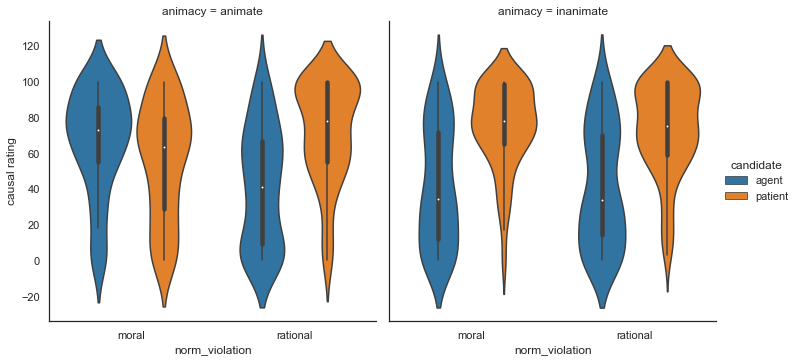

In [24]:
e2dat_long = e2dat.melt(id_vars=['prolificID', 'animacy', 'norm_violation'], value_vars=['agent', 'patient'],
                    var_name='candidate', value_name='causal rating')
sns.catplot(x='norm_violation', y='causal rating', hue='candidate', col='animacy', kind='violin', data=e2dat_long)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


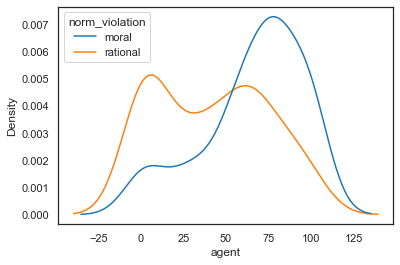

In [30]:
sns.kdeplot(data=e2dat.loc[e2dat.animacy=='animate'], x='agent', hue='norm_violation')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


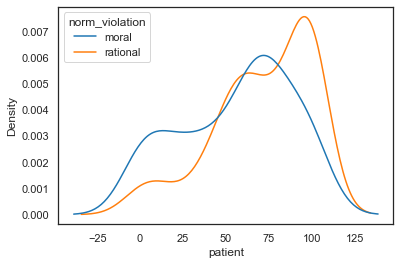

In [27]:
sns.kdeplot(data=e2dat.loc[e2dat.animacy=='animate'], x='patient', hue='norm_violation')

### Q0: \"If AGENT had not been there, the tower would have remained standing.\"
### Q1: \"If PATIENT had not been there, the tower would have remained standing.\"
### Q2: \"I expected AGENT to move in a different way than it did in the video. \"
### Q3: \"If AGENT  had moved in a different way, the tower would have remained standing.\"

Animate-Rational

In [18]:

e2_anim_rat = e2dat.loc[(e2dat.animacy == 'animate') & (e2dat.norm_violation == 'rational')]
e3_anim_rat = dat.loc[(dat.animacy == 'animate') & (dat.norm_violation  == 'rational')]

In [23]:
e2dat.groupby(['animacy', 'norm_violation']).count.mean()

animacy    norm_violation
animate    moral             66.214286
           rational          41.567010
inanimate  moral             41.663265
           rational          41.244898
Name: agent, dtype: float64

In [15]:
dat['condition'] = [str(dat.condition[x]) for x in range(len(dat))]

['animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'animate',
 'an

In [20]:
dat['cond'] = dat.condition.map(lambda x: x.split('_'))

In [24]:
dat['cond'][0].transform({'item1': itemgetter(0), 'item2': itemgetter(1)})

AttributeError: 'list' object has no attribute 'transform'